
# Section 5: Learning from only one sample: simple siamese neural networks
## Video 1: Discussion on methods with one sample (intro dataset)

Download the dataset here: https://github.com/brendenlake/omniglot

In [1]:
import sys
import numpy as np
from scipy.misc import imread
import os
import matplotlib.pyplot as plt

data_path = "datasets/omniglot/python/"
train_path = os.path.join(data_path,'images_background')
validation_path = os.path.join(data_path,'images_evaluation')

def load_images_from_directory(path,n=0):
    X=[]
    
    ## We load every alphabet seperately and append that to one tensor
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        alphabet_path = os.path.join(path,alphabet)
        
        ## Each character in alphabet is in a separate folder
        for letter in os.listdir(alphabet_path):
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
      
            if not os.path.isdir(letter_path):
                continue

            ## Read every image in this directory
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
            
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
    
    X = np.stack(X)
    return X

print("Loading training set")
Xtrain = load_images_from_directory(train_path)
print(Xtrain.shape)

print("Now loading evaluation set")
Xval = load_images_from_directory(validation_path)
print(Xval.shape)

Loading training set
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Japanese_(hiragana)
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Latin
loading alphabet: Greek
loading alphabet: Japanese_(katakana)
loading alphabet: Grantha
loading alphabet: N_Ko
loading alphabet: Balinese
loading alphabet: Tagalog
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Futurama
loading alphabet: Tifinagh
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Gujarati
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Cyrillic
loading alphabet: Sanskrit
loading alphabet: 

In [2]:
import numpy.random as rng

def get_batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    ## Initialise data we return in memory
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    ## Make a target vector with half same and half other categories
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    ## Pick the categories of characters we will return
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    for i in range(batch_size):
        category = categories[i]
        
        ## Choose two indixes from the amount of examples (20) we have
        idx_1 = rng.randint(0, n_examples)
        idx_2 = rng.randint(0, n_examples)
        
        #pick images of same class for 1st half, different for 2nd
        if targets[i] == 1:
            category_2 = category # if target is set: pick from same category
        else:
            ## Pick new class by picking random number 
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[0][i,:,:,:] = data[category,idx_1].reshape(w,h,1)
        pairs[1][i,:,:,:] = data[category_2,idx_2].reshape(w,h,1)
  
    return pairs, targets


def make_oneshot_task(data, N):
    n_val, n_ex_val, w, h = data.shape

    categories = rng.choice(n_val,size=(N,),replace=False)
    true_category = categories[0]
    
    indices = rng.randint(0, n_ex_val,size=(N,))
    
    ex1, ex2 = rng.choice(n_ex_val,replace=False,size=(2,))
    
    ## Create a list with the same image N times as test image
    test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    
    support_set = data[categories,indices,:,:]
    
    ## Create the targets and fill in true character
    targets = np.zeros((N,))    
    targets[0] = 1 # Set the first target to be the true character
    support_set[0,:,:] = data[true_category,ex2] # Fill in this caracter
    
    
    ## Reshape the data and return it
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image,support_set]
    return pairs, targets

In [3]:

# class Siamese_Loader:
#     """For loading batches and testing tasks to a siamese net"""
#     def __init__(self,Xtrain,Xval):
#         self.Xval = Xval
#         self.Xtrain = Xtrain
#         self.n_classes,self.n_examples,self.w,self.h = Xtrain.shape
#         self.n_val,self.n_ex_val,_,_ = Xval.shape

#     def get_batch(self,n):
#         """Create batch of n pairs, half same class, half different class"""
#         categories = rng.choice(self.n_classes,size=(n,),replace=False)
#         pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
#         targets=np.zeros((n,))
#         targets[n//2:] = 1
#         for i in range(n):
#             category = categories[i]
#             idx_1 = rng.randint(0,self.n_examples)
#             pairs[0][i,:,:,:] = self.Xtrain[category,idx_1].reshape(self.w,self.h,1)
#             idx_2 = rng.randint(0,self.n_examples)
#             #pick images of same class for 1st half, different for 2nd
#             category_2 = category if i >= n//2 else (category + rng.randint(1,self.n_classes)) % self.n_classes
#             pairs[1][i,:,:,:] = self.Xtrain[category_2,idx_2].reshape(self.w,self.h,1)
#         return pairs, targets

#     def make_oneshot_task(self,N):
#         """Create pairs of test image, support set for testing N way one-shot learning. """
#         categories = rng.choice(self.n_val,size=(N,),replace=False)
#         indices = rng.randint(0,self.n_ex_val,size=(N,))
#         true_category = categories[0]
#         ex1, ex2 = rng.choice(self.n_examples,replace=False,size=(2,))
#         test_image = np.asarray([self.Xval[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
#         support_set = self.Xval[categories,indices,:,:]
#         support_set[0,:,:] = self.Xval[true_category,ex2]
#         support_set = support_set.reshape(N,self.w,self.h,1)
#         pairs = [test_image,support_set]
#         targets = np.zeros((N,))
#         targets[0] = 1
#         return pairs, targets


## Video 3: Training and testing your network. 

https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

https://sorenbouma.github.io/blog/oneshot/

## Video 2: Defining a good loss function


2


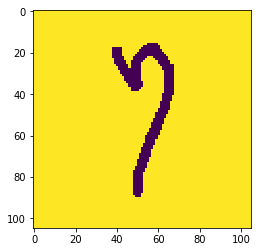

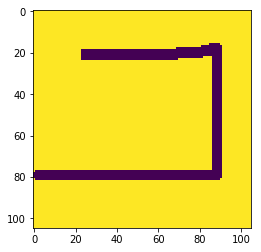

Is the same: 0.0


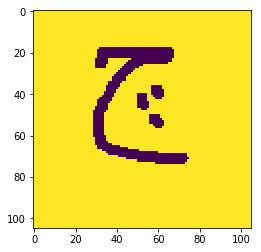

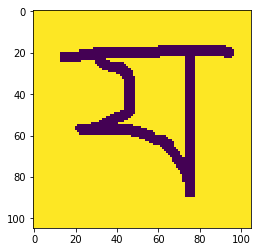

Is the same: 0.0


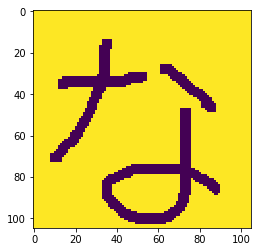

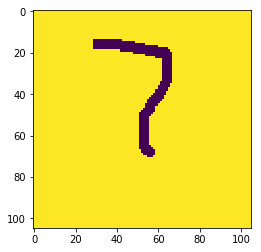

Is the same: 0.0


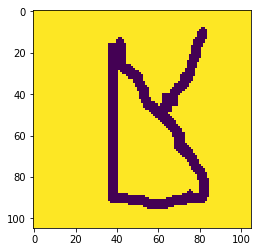

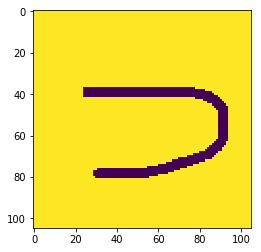

Is the same: 0.0


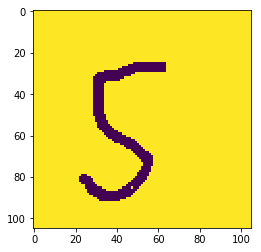

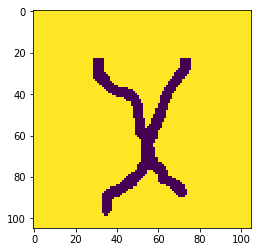

Is the same: 0.0


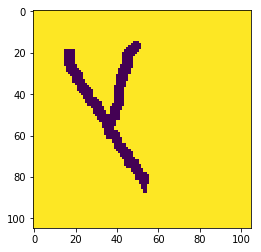

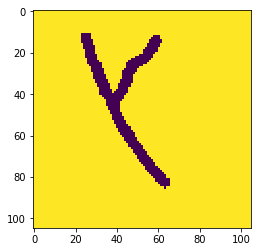

Is the same: 1.0


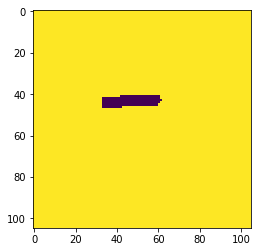

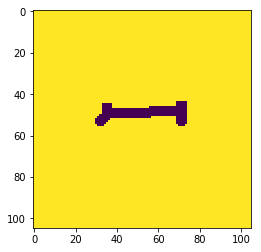

Is the same: 1.0


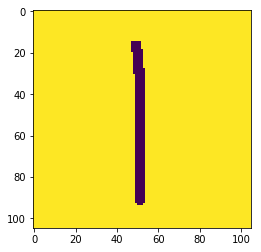

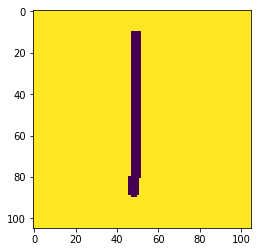

Is the same: 1.0


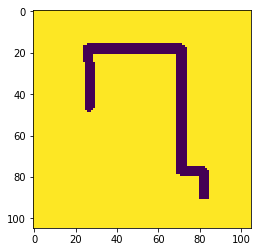

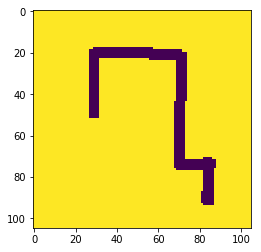

Is the same: 1.0


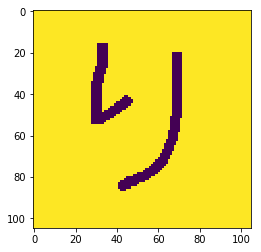

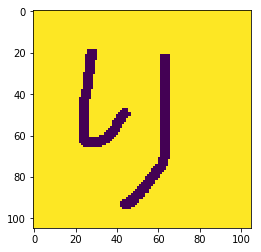

Is the same: 1.0


In [4]:
pairs, targets = get_batch(Xtrain, 10)
print(len(pairs))
for i in range(len(pairs[0])):

    #print(pairs[0][i].shape)    
    image = np.reshape(pairs[0][i],(105,105))
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()
    print("Is the same: " + str(targets[i]))


In [5]:
logging_dir_n = 0

In [80]:

# prints
# [u'conv/kernel:0', u'conv/bias:0']
import numpy as np
def get_input_pipeline(x_input, reuse):
    with tf.variable_scope("first_part", reuse=reuse):
        rand_norm_std = 0.5
#         conv1 = tf.layers.conv2d(x_input, 64, [10, 10], name='conv1', activation=tf.nn.relu, padding="same")
        conv1 = tf.layers.conv2d(x_input, 32, [10, 10], name='conv1', activation=tf.nn.relu)#, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
#         conv2 = tf.layers.conv2d(maxp1, 64, [7, 7], name='conv2', activation=tf.nn.relu, padding="same")
        conv2 = tf.layers.conv2d(maxp1, 64, [5, 5], name='conv2', activation=tf.nn.relu)#, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
#         conv3 = tf.layers.conv2d(maxp2, 128, [4, 4], name='conv3', activation=tf.nn.relu, padding="same")
        conv3 = tf.layers.conv2d(maxp2, 128, [3, 3], name='conv3', activation=tf.nn.relu)#, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')
        #
#         conv4 = tf.layers.conv2d(maxp3, 256, [3, 3], name='conv4', activation=tf.nn.relu, padding="same")
        conv4 = tf.layers.conv2d(maxp3, 128, [3, 3], name='conv4', activation=tf.nn.relu)#, activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        
        conv5 = tf.layers.conv2d(conv4, 32, [1, 1], name='conv5')
    
        flattened = tf.contrib.layers.flatten(conv5)
        print(flattened)
        #dense1 = tf.layers.dense(flattened, 4096, activation=tf.nn.sigmoid, name="dense1")
        dense1 = tf.layers.dense(flattened, 4096, activation=tf.nn.sigmoid, name="dense1")
        
    return dense1

import tensorflow as tf
tf.reset_default_graph()
image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1])
image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1])
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1])

out_1 = get_input_pipeline(image1, None)
out_2 = get_input_pipeline(image2, True)
print([x.name for x in tf.global_variables()])

#l_one = tf.concat([out_1, out_2], axis=1)
l_one = tf.abs(tf.subtract(out_1,out_2))
print(l_one)
#l_one_sig = tf.nn.sigmoid(l_one)

#dense_together = tf.layers.dense(l_one_sig, 1024, activation=tf.nn.relu, name="before_output")
#dense_together2 = tf.layers.dense(dense_together, 512, activation=tf.nn.relu, name="just_before_output")
prediction = tf.layers.dense(l_one, 1, activation=None, name="output")



global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.9
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1, 0.99, staircase=True)

# prints
# [u'conv/kernel:0', u'conv/bias:0']



Tensor("first_part/Flatten/Reshape:0", shape=(?, 2048), dtype=float32)
Tensor("first_part_1/Flatten/Reshape:0", shape=(?, 2048), dtype=float32)
['first_part/conv1/kernel:0', 'first_part/conv1/bias:0', 'first_part/conv2/kernel:0', 'first_part/conv2/bias:0', 'first_part/conv3/kernel:0', 'first_part/conv3/bias:0', 'first_part/conv4/kernel:0', 'first_part/conv4/bias:0', 'first_part/conv5/kernel:0', 'first_part/conv5/bias:0', 'first_part/dense1/kernel:0', 'first_part/dense1/bias:0']
Tensor("Abs:0", shape=(?, 4096), dtype=float32)


In [81]:
def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
        x: An object to be converted (numpy array, list, tensors).
        dtype: The destination type.
    # Returns
        A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def epsilon():
    return 1e-07

# def my_crossentropy(target, output):
#     # transform back to logits
#     _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
#     output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
#     output = tf.log(output / (1 - output))

#     return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
#                                                    logits=output)

def thesis_crossentropy(label, prediction):
    print(label)
    print(prediction)
    pred1 = tf.sigmoid(prediction)
    print(pred1)
    eding = _to_tensor(epsilon(), prediction.dtype.base_dtype)
    output = tf.clip_by_value(pred1, eding, 1 - eding)
    pred1 = tf.log(output)

    a1 = tf.multiply(label, tf.log(pred1))
    print(a1)
    a2 = tf.multiply((1-label), tf.log(1-pred1))
    print(a2) 
    
    a3 = a1 + a2
    print(a3)
    return tf.reduce_mean(a3)
sigpred = tf.nn.sigmoid(prediction)

# epsilon = 0.001
# clipped_pred = tf.clip_by_value(sigpred,epsilon,1-epsilon,name="clippingtool")
# log_true = -tf.log(clipped_pred)
# log_false = -tf.log(1-clipped_pred)

# print(log_true)
# print(log_false)
# loss = tf.multiply(label_placeholder,log_true) + tf.multiply(1-label_placeholder,log_false)
# loss = tf.reduce_sum(loss)
# print(loss)

loss = tf.losses.mean_squared_error(label_placeholder,sigpred)
#loss = thesis_crossentropy(label_placeholder, prediction)
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder, logits=prediction))
# loss = my_crossentropy(label_placeholder, prediction)
#loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=label_placeholder, logits=prediction))

testloss = tf.identity(loss, name="testlossvec")
training_summary = tf.summary.scalar('loss', loss)
testing_summary = tf.summary.scalar('testloss', testloss)
merged = tf.summary.merge_all()

#w = tf.get_variable_by_name("first_part/conv1/kernel")
a = [v for v in tf.global_variables()][0]

histograms = []
for v in tf.global_variables():
    if "kernel" in v.name:
        toadd = tf.summary.histogram(v.name[:-3], v)
        histograms.append(toadd)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#optimizer = tf.train.AdamOptimizer().minimize(loss)

In [82]:
print(label_placeholder)
print(prediction)

Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
Tensor("output/BiasAdd:0", shape=(?, 1), dtype=float32)


In [83]:

writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1
writer.flush()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    



In [84]:
#siam_loader = Siamese_Loader(Xtrain, Xval)
BATCH_SIZE = 32
for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, l, summary = sess.run([optimizer, loss, training_summary], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    print(l)
    writer.add_summary(summary, iteration)
    eval_histos = sess.run(histograms)
    for haatje in eval_histos:
        writer.add_summary(haatje, iteration)
    if iteration %10 == 0:
        pairs, targets = get_batch(Xtrain, 6)
        sp, pr = sess.run([sigpred, prediction], feed_dict={image1: pairs[0], image2: pairs[1]})
        print("sigpred:")
        print(sp)
        print("prediction")
        print(pr)
        print("targets: ")
        print(targets)
        
        pairs, targets = get_batch(Xval, BATCH_SIZE)
        targets = [[t] for t in targets]
        _, m = sess.run([testloss, testing_summary], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
        writer.add_summary(m, iteration)

0.250077
sigpred:
[[ 0.41650972]
 [ 0.46907327]
 [ 0.44541124]
 [ 0.40452027]
 [ 0.4292739 ]
 [ 0.37263721]]
prediction
[[-0.33711803]
 [-0.12386506]
 [-0.2192288 ]
 [-0.38666546]
 [-0.28481412]
 [-0.5209195 ]]
targets: 
[ 0.  0.  0.  1.  1.  1.]
0.242338
0.251198
0.250851
0.250346
0.249528
0.250247
0.248955
0.249406
0.249355
0.250101
sigpred:
[[ 0.4968217 ]
 [ 0.50419295]
 [ 0.50013024]
 [ 0.50002241]
 [ 0.50042886]
 [ 0.50363892]]
prediction
[[ -1.27131781e-02]
 [  1.67722702e-02]
 [  5.20965084e-04]
 [  8.96222191e-05]
 [  1.71544752e-03]
 [  1.45558678e-02]]
targets: 
[ 0.  0.  0.  1.  1.  1.]
0.249601
0.250406
0.250591
0.249684
0.250184
0.25015
0.25
0.250163
0.25
0.249999
sigpred:
[[ 0.50054175]
 [ 0.50054175]
 [ 0.50044292]
 [ 0.50054199]
 [ 0.50045508]
 [ 0.50054199]]
prediction
[[ 0.00216688]
 [ 0.002167  ]
 [ 0.00177155]
 [ 0.00216804]
 [ 0.00182027]
 [ 0.00216794]]
targets: 
[ 0.  0.  0.  1.  1.  1.]
0.249987
0.25
0.250269
0.25
0.25
0.25
0.25
0.25
0.25
0.25
sigpred:
[[ 0.5005

0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
sigpred:
[[ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]]
prediction
[[ -1.22209417e-06]
 [ -1.22209417e-06]
 [ -1.22209417e-06]
 [ -1.22209417e-06]
 [ -1.22209417e-06]
 [ -1.22209417e-06]]
targets: 
[ 0.  0.  0.  1.  1.  1.]
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
sigpred:
[[ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]
 [ 0.4999997]]
prediction
[[ -1.17058710e-06]
 [ -1.17058710e-06]
 [ -1.17058710e-06]
 [ -1.17058710e-06]
 [ -1.17058710e-06]
 [ -1.17058710e-06]]
targets: 
[ 0.  0.  0.  1.  1.  1.]
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
sigpred:
[[ 0.49999976]
 [ 0.49999976]
 [ 0.49999976]
 [ 0.49999976]
 [ 0.49999976]
 [ 0.49999976]]
prediction
[[ -8.20316870e-07]
 [ -8.20316870e-07]
 [ -8.20316870e-07]
 [ -8.20316870e-07]
 [ -8.20316870e-07]
 [ -8.20316870e-07]]
targets: 
[ 0.  0.  0.  1.  1.  1.]
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25


In [78]:

## Determine the accuracy 
CHOOSE_FROM_N = 5
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    #inputs, targets = siam_loader.make_oneshot_task(CHOOSE_FROM_N)
    
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
    #print(pred)
    #print(targets)
    maxindex = np.argmax(pred)

    if maxindex == 0:
        correct_tested += 1
print(correct_tested/TEST_COUNT)


0.52


In [ ]:
## DEBUG FUCKING FUNCTIE

pairs, targets = siam_loader.get_batch(2)
newt = list()
for t in targets:
    if t == 1:
        newt.append([0,1])
    else:
        newt.append([1,0])

l, o1, o2, pred = sess.run([loss, out_1, out_2, prediction], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: newt})

print(l)
print(pred)

In [ ]:
print(pred)
print(o1)
print(o2)

In [ ]:
pairs, targets = siam_loader.get_batch(BATCH_SIZE)
targets = [[t] for t in targets]
_, l, summary = sess.run([optimizer, loss, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
print(l)
writer.add_summary(summary, iteration)

In [ ]:
pairs, targets = siam_loader.get_batch(1)
targets = [[t] for t in targets]
a1, a2 = sess.run([out_1, out_2], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
print(a1)
print(a2)

In [ ]:
pairs, targets = siam_loader.get_batch(6)
targets = [[t] for t in targets]
pred = sess.run(prediction, feed_dict={image1: pairs[0], image2: pairs[1]})
for index in range(len(targets)):
    print(index)
    print(pred[index])
    print(targets[index])
    im = np.reshape(pairs[0][index], (105, 105))
    plt.imshow(im)
    plt.show()
    im2 = np.reshape(pairs[1][index], (105, 105))
    plt.imshow(im2)
    plt.show()
    


In [ ]:
inputs, targets = siam_loader.make_oneshot_task(5)
# print(len(inputs))
# print(len(targets))
# print(inputs[0].shape)
# print(inputs[1].shape)
# print(targets.shape)


pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
print(np.argmax(pred))

# print(pred)
# print(targets)

maxindex = np.argmax(pred)
if maxindex == 0:
    print("Correct")
else:
    print("Incorrect")
im = np.reshape(inputs[0][maxindex], (105, 105))
plt.imshow(im)
plt.show()

im = np.reshape(inputs[1][maxindex], (105, 105))
plt.imshow(im)
plt.show()


# for index in range(len(targets)):
#     im = np.reshape(inputs[0][index], (105, 105))
#     plt.imshow(im)
#     plt.show()
#     im = np.reshape(inputs[1][index], (105, 105))
#     plt.imshow(im)
#     plt.show()
#     print(pred[index][0])
#     print(targets[index])
